# Homework 8 - Deep Learning


This assignment will give you practice using the library PyTorch, which is a popular library for constructing deep learning models. Deep Learning is a very powerful tool because it is able to learn very complicated functions. Deep Learning has revolutionized fields like image and speech recognition.

The specific task we are trying to solve in this assignment is image classification. We will be using a very commong dataset called CIFAR-10 that has 60,000 images separated into 10 classes. The classes are
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

In this assignment, you will practice:
* Reading documentation for a modern machine learning library
* Writing PyTorch code.
* Evaluating neural network models.

Fill in the cells provided marked `TODO` with code to answer the questions. **Unless otherwise noted, every answer you submit should have code that clearly shows the answer in the output.** Answers submitted that do not have associated code that shows the answer may not be accepted for credit.

**Make sure to restart the kernel and run all cells** (especially before turning it in) to make sure your code runs correctly. Answer the questions on Gradescope and make sure to download this file once you've finished the assignment and upload it to Canvas as well. **Note this assignment takes a long time to run so make sure to do this earlier than later**.

> Copyright ©2021 Hunter Schafer.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2021 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

---
# Step 1 - Background Reading
Before starting this assignment, you should familiarize yourself with PyTorch. You should read [their tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and preferably follow along with a Colab notebook. You should only have to fully read the sections:
* "What is PyTorch?"
* *Optional* "Autograd: Automatic Differentiation"
* "Neural Networks"
* "Training a Classifier"

This should take about an hour (according to the name of the tutorial). Once you are done with that, you should be more ready to tackle this assignment!

You will probably also want to look at the [documentation](https://pytorch.org/docs/stable/index.html) to understand what parameters they are specifying in the tutorial.

# Assignment
**Before you start, make sure you have enabled GPU for your Colab Runtime.** In the Runtime drop down above, click on "Change runtime type" and select "GPU" in the Hardware Accelerator field.

First we import all of the modules we will use in this assignment.

In [19]:
import math

import matplotlib.pyplot as plt              # For plotting
import seaborn as sns                        # For styling plots
import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters
import torchvision.datasets as datasets      # To download data
import torchvision.transforms as transforms  # For pre-processing data

sns.set()

Then we define some constants that will be used throughout the program.

In [20]:
INPUT_SIZE    = 3 * 32 * 32   # An image has 32 x 32 pixels each with Red/Green/Blue values.
NUM_CLASSES   = 10            # The number of output classes. In this case, from 0 to 9
NUM_EPOCHS    = 10            # The number of times we loop over the whole dataset during training
BATCH_SIZE    = 100           # The size of input data took for one iteration of an epoch
LEARNING_RATE = 1e-3          # The speed of convergence

The first step is to download the dataset using PyTorch. The code below produces a train set and a test set. Some notes on PyTorch terminology:
* Most of the time we use the `train_loader` instead of the `trainset`. The reason being the loader gives us batches of examples from the entire `trainset`. Looping over the `train_loader` returns a subset of the examples on each iteration.
* PyTorch commonly talks about "tensors". For our purposes, a tensor is just a multi-dimensional array. For example, the `trainset` is a tensor with shape `(50000, 32, 32, 3)` because there are 50,000 images, each is 32x32 pixels with 3 color channels (Red / Green / Blue). You can index into these just like `numpy` arrays.
* We pre-process the data into tensors and the normalize them so all the pixels have mean 0.5 and standard devaition 0.5.
* Training the models on the full dataset can take a long time. We have left some commented out code to help you sample the training/test data to speed up development time. We encourage you to un-comment the code line while you are figuring out how to write the code so it takes less time to run as long as you re-comment the lines out before training your final models.  

**IMPORTANT: Make sure you comment the sampling lines out and re-run your solution on the full dataset to get the correct results.** If you do not correctly train the models on the full dataset in your final submission, you will not get full credit.  

In [21]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True,
                            transform=transform)
# Uncomment line below to speed up train time when testing if your code works.
# MAKE SURE TO RECOMMENT THE LINE OF CODE BEFORE SUBMITTING. Otherwise your results will be wrong.
# trainset, _ = torch.utils.data.random_split(trainset, [BATCH_SIZE * 10, len(trainset) - BATCH_SIZE * 10])

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True,
                           transform=transform)
# Uncomment line below to speed up train time when testing if your code works.
# MAKE SURE TO RECOMMENT THE LINE OF CODE BEFORE SUBMITTING. Otherwise your results will be wrong.
# testset, _ = torch.utils.data.random_split(testset, [BATCH_SIZE * 10, len(testset) - BATCH_SIZE * 10])
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


----
In the cell below, we define the critical helper functions to train and visualize the results of the neural networks.

You should read and understand what they are doing since the next step will ask you to modify one of them.

In [22]:
# TODO Edit this cell as described
def train(net, train_loader, test_loader,
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
          compute_accs=False):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   # Loop over each batch in train_loader

            # If you are using a GPU, speed up computation by moving values to the GPU
            if torch.cuda.is_available():
                net = net.cuda()
                images = images.cuda()
                labels = labels.cuda()


            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes

            if batch_num % 100 == 0:  # Print every 100 batches
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

            batch_num += 1

        train_acc = accuracy(net, train_loader)
        test_acc = accuracy(net, test_loader)
        print(f'Epoch [{epoch}/{num_epochs}], Train Accuracy {100 * train_acc:.2f}%, Test Accuracy {100 * test_acc:.2f}%')
        train_accs.append(train_acc)
        test_accs.append(test_acc)


    if compute_accs:

        return train_accs, test_accs
    else:
        return None


def accuracy(net, data_loader):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        if  torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained.
                   Each dictionary should have the keys:
                        * name: The model name
                        * train_accs: A list of train accuracies
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      val = plt.plot(epochs, model_history['test_accs'],
                     '--', label=model_history['name'] + ' Test')
      plt.plot(epochs, model_history['train_accs'], color=val[0].get_color(),
               label=model_history['name'] + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])


## Step 2
Right now the `train` function works, but we want to add extra functionality so that it keeps track of how the train/test accuracies change as training progresses (if the `compute_accs` parameter is true). It would be very inefficient to evaluate the train/test accuracy at the end of each batch, so instead we should only evaluate it at the end of each training epoch.

Modify the code so that at the end of each epoch if `compute_accs` is true, it computes the training and test accuracies and puts those values at the end of  `train_accs` and `test_accs` respectively.

To help you understand your model's progress while training, it will also be helpful to include a print statement in the code you write to print out the training/test accuracy when you evaluate it. The print statement can look something like:

```python
print(f'Epoch [{epoch}/{num_epochs}], Train Accuracy {100 * train_acc:.2f}%, Test Accuracy {100 * test_acc:.2f}%')

```

----

## Step 3
Now with all the helper code done, we are going to actually write the PyTorch code that specifies the neural network models. Each of the models described should be a different Python class with the specified name.

### `NetA`
The first neural network will be the simplest, in that it has no hidden layers. It should take the image and flatten it to a vector for the input, and then have 10 outputs, one for each class.

There should be no non-linearities for this network and is just a very simple linear classifier.


### `NetB`
The second neural network will be slightly more complicated in that it has a hidden layer with 300 nodes and adds a non-linearity between the layers. It should use the following operations in this order:
* Flatten the image to a vector for the input
* Use a fully-connected linear layer with 300 hidden-neurons
* Use the ReLU activation function
* Use a fully-connected linear layer to the 10 outputs.

### `NetC`
This third neural network will be a convolutional neural network. It should use the following operations in this order:
* Use a convolution layer with kernel-width 5 and depth 25
* Use the ReLU activation function
* Use a max-pool operation with kernel-width 2 and stride 2
* Flatten the image to a vector for the next step's input
* Use a fully-connected linear layer to the 10 outputs.

This architecture can be seen visually in the following diagram (the left-most object is the input image).

![Network Architecture](https://courses.cs.washington.edu/courses/cse416/19su/files/assignment-resources/homework/hw7/nn.svg)

Notice that these diagrams use the notation
```
channels @ height x width
```
to describe the dimensions of the results at each step.

### `NetD`
This is your chance to try out some different architectures of your choice. Create your own neural network architecture that has **at least 2 convolution layers** and **at least 2 fully connected layers**. Your goal is to pick a network architecture that achieves at least 65% test accuracy. Most of the points for this problem are based on having a model that meets the minimum layer requirements, with fewer points focusing on the accuracy.

*Implementation details/notes*:
* For simplicity, your model should be able to be trained with the same learning rate and optimizer as the other models. This is a restriction that is not normal in real-practice, but we want you to follow this to simplify the code and our grading.
* Every convolution operation should be followed by a pooling operation.
* Every linear layer and convolution layer should have an activation function. However, it is common to not have one on the very last layer to the 10 outputs so you do not need one there.
* You will likely want to use `NetC` as a starting point!
* It is not required, but it might help to make your code more modular by adding parameters to the constructor to specify numbers that contain details about the architecture. Then you can automate trying many different settings of these hyper-parameters. If you do add these parameters, modify the cell later that produces the training plots to pass in the appropriate parameter values.

In [23]:
# TODO Write the network architectures here
class NetA(nn.Module):
    def __init__(self):
        super(NetA, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 10)

    def forward(self,x):
        x = self.flatten(x)
        x = self.fc1(x)
        return x

class NetB(nn.Module):
    def __init__(self):
        super(NetB, self).__init__()
        self.fc1 = nn.Linear(3*32*32,300)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(300, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class NetC(nn.Module):
    def __init__(self):
        super(NetC, self).__init__()
        self.conv1 = nn.Conv2d(3, 25, kernel_size = 5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(25*14*14,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

class NetD(nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*6*6,128)
        self.fc2 = nn.Linear(128,10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=32,kernel_size = 3, stride  =1, padding = 0)
dummy_input = torch.randn(1,1,28,28)
output = conv_layer(dummy_input)
print(output.size())

#output size = ((input_size - kernel_size+2*padding)/stride)+1)
# output_layer_dimension = output_size * output_size * number of kernels(output_channels)
# flatten it and connect to the fully connected layer at the end for 1 dimensions 
# kernel - convolutional layer your are using 
# using 32  3*3 kernels, 32 kernels that have channel 3, out put layer 



Below is the cell that runs the main part of the code. It trains each of the 4 models you specified above for 10 epochs and then plots their train/test accuracies throughout the training process. When training all 4 models on the entire datasets, this should take about 15 minutes to run.

You are welcome to change the `nets` list during development so you don't have to train all 4 models each time, but make sure your final result trains:

```
nets = [NetA(), NetB(), NetC(), NetD()]
```

==== Training NetA ====
Epoch [1/10], Step [100/500], Loss: 1.8646
Epoch [1/10], Step [200/500], Loss: 1.8113
Epoch [1/10], Step [300/500], Loss: 1.8308
Epoch [1/10], Step [400/500], Loss: 1.8217
Epoch [1/10], Step [500/500], Loss: 1.7500
Epoch [1/10], Train Accuracy 39.06%, Test Accuracy 37.14%
Epoch [2/10], Step [100/500], Loss: 1.7642
Epoch [2/10], Step [200/500], Loss: 1.7483
Epoch [2/10], Step [300/500], Loss: 1.8927
Epoch [2/10], Step [400/500], Loss: 1.6976
Epoch [2/10], Step [500/500], Loss: 1.9114
Epoch [2/10], Train Accuracy 41.87%, Test Accuracy 39.56%
Epoch [3/10], Step [100/500], Loss: 1.5667
Epoch [3/10], Step [200/500], Loss: 1.8529
Epoch [3/10], Step [300/500], Loss: 1.9709
Epoch [3/10], Step [400/500], Loss: 1.8695
Epoch [3/10], Step [500/500], Loss: 1.6430
Epoch [3/10], Train Accuracy 41.00%, Test Accuracy 37.36%
Epoch [4/10], Step [100/500], Loss: 1.6476
Epoch [4/10], Step [200/500], Loss: 1.7451
Epoch [4/10], Step [300/500], Loss: 1.9614
Epoch [4/10], Step [400/500]

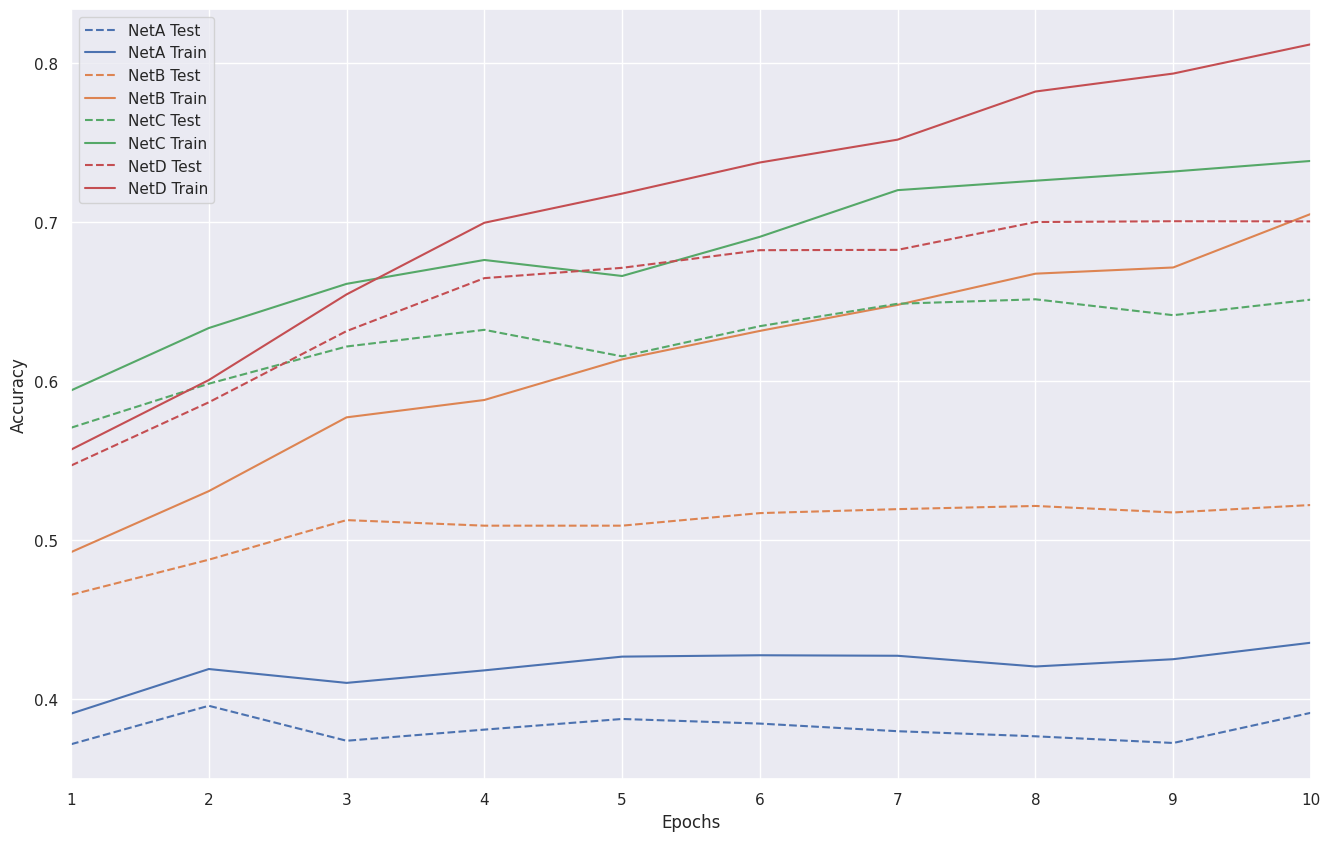

In [24]:
%%time
nets = [NetA(), NetB(), NetC(), NetD()]
histories = []

for net in nets:
    net_name = type(net).__name__
    print(f'==== Training {net_name} ====')
    train_history, test_history = train(net, train_loader, test_loader,
                                        num_epochs=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        compute_accs=True)
    histories.append({
        'name': net_name,
        'net': net,
        'train_accs': train_history,
        'test_accs': test_history
    })
plot_history(histories)

# Before you submit
Make sure you have undone any changes to the starter code that impact model training you were not asked to change. Specifically look for the development tips we suggested to undo those changes
* Make sure your models are trainied on the whole dataset by re-commenting the sampling lines at earlier in the notebook. Together, the 4 models should take about 15 minutes to train if you are using the whole dataset.
* Make you are training all 4 of `NetA`, `NetB`, `NetC`, and `NetD`. Your final plot should show these 4 models' training/test accuracies during over the training phase.
* Make sure you have run all the cells and the graph appears in your notebook. For grading, we need to see the desired output in your notebook.

# To Submit
Download the notebook from Colab as a `.ipynb` notebook (`File > Download > Download .ipynb`) and upload it to the Gradescope assignment for this assignment. Your assignment should be named `HW8-Deep-Learning-with-PyTorch.ipynb`.